# Leadangle_fitplot3.ipynb

`Leadangle_fit.py`で計算した結果をプロットする。

In [19]:
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [20]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v / vmax, c))
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

whiteblue=generate_cmap(['#000000','#010E5E','#042AA6','#0F7CE0','#1AC7FF','#FFFFFF'])

In [21]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [22]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [23]:
# 定数
r_orbitM = 9.38*RJ   # ORBITAL RADIUS (average) [m] (Bagenal+2015)
r_orbitC = 9.30*RJ   # ORBITAL RADIUS (closest) [m] (Bagenal+2015)
r_orbitF = 9.47*RJ   # ORBITAL RADIUS (farthest) [m] (Bagenal+2015)
MOONRADI = 1.56E+6   # MOON RADIUS [m]
OMG_E = 2.0478E-5    # 衛星の公転角速度 [rad/s]
n0 = 110             # [cm-3] (Cassidy+2013)

ne_1 = 63            # 電子数密度 [cm-3] (Bagenal+2015)
ne_2 = 158           # 電子数密度 [cm-3] (Bagenal+2015)
ne_3 = 290           # 電子数密度 [cm-3] (Bagenal+2015)

Ai = 18              # 平均イオン原子量 (Bagenal+2015)
Zi = 1.4             # 平均イオン価数 [q] (Bagenal+2015)

Ti_14 = 68           # 平均イオン温度 [eV] (Best fit 2014_6)
rho0_14 = 1862       # プラズマ質量密度 [amu cm-3] (Best fit 2014_6)

Ti_22 = 138          # 平均イオン温度 [eV] (Best fit 2022_6)
rho0_22 = 2684       # プラズマ質量密度 [amu cm-3] (Best fit 2022_6)

Ti_14 = 74           # 平均イオン温度 [eV] (Best fit 2014_7)
rho0_14 = 1686       # プラズマ質量密度 [amu cm-3] (Best fit 2014_7)

Ti_22 = 134          # 平均イオン温度 [eV] (Best fit 2022_7)
rho0_22 = 2801       # プラズマ質量密度 [amu cm-3] (Best fit 2022_7)

Ti_PJ26 = 53         # 平均イオン温度 [eV] (Best fit PJ26)
rho0_PJ26 = 2868     # プラズマ質量密度 [amu cm-3] (Best fit PJ26)

H_p = 1.8*RJ         # [m]
Hp0 = 0.64*RJ        # 基準スケールハイト [m] (Bagenal&Delamere2011)
wlonN = copy.copy(satovalN.wlon)
FwlonN = copy.copy(satovalN.euwlon)
FlatN = copy.copy(satovalN.eulat)
FwlonS = copy.copy(satovalS.euwlon)
FlatS = copy.copy(satovalS.eulat)

OMGR = OMGJ-OMG_E

In [24]:
# Plasma sheet scale height
Hp_14 = Hp0*math.sqrt(Ti_14/Ai)       # Scale height [m] (Bagenal&Delamere2011)
Hp_22 = Hp0*math.sqrt(Ti_22/Ai)       # Scale height [m] (Bagenal&Delamere2011)
Hp_PJ26 = Hp0*math.sqrt(Ti_PJ26/Ai)   # Scale height [m] (Bagenal&Delamere2011)

# STIS Jan2014 Oct2022

In [25]:
# HST data
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

hem = 'North'

north_doy14 = ['14/006_v06', '14/013_v13', '14/016_v12']
north_doy22 = ['22/271_v18', '22/274_v17']
north_doy = north_doy14 + north_doy22
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']
# south_doy = ['22/185_v09', '22/185_v09_MAW_']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 'N'
if hem == 'South':
    refnum = 'S'
satoval = np.recfromtxt('data/JRM33/satellite_foot_'+refnum+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

# 等高線

(array([20]), array([40])) rho_min [1703.49766284] Ti_min [72.49782206]
(array([30]), array([51])) rho_min [2746.3262062] Ti_min [138.02966758]


[]

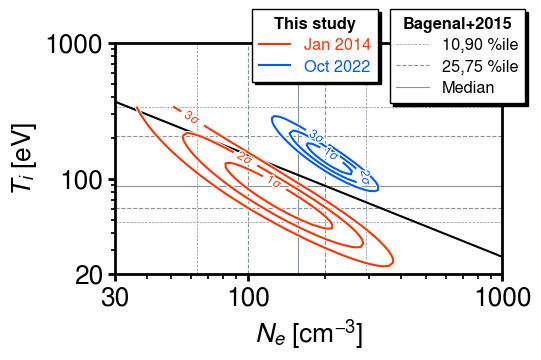

In [26]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(figsize=(5,3), dpi=100)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax.set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(30,1000)
ax.set_ylim(20,1000)
ax.set_xticks(np.array([30,100,1000], dtype=int))
ax.set_xticklabels(np.array([30,100,1000], dtype=int))
ax.set_yticks(np.array([20,100,1000], dtype=int))
ax.set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax.contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax.clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

ax.plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax.axhline(y=340, color=cud4bs[7], linewidth=0.5, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax.axvline(x=63, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # H/C
ax.axhline(y=205, color=cud4bs[7], linewidth=0.8, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax.axvline(x=100, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 25
ax.axhline(y=88, color=cud4bs[7], linewidth=0.8, label='Median', zorder=0.9)  # Medium
ax.axvline(x=158, color=cud4bs[7], linewidth=0.8, zorder=0.9)                        # Medium
ax.axhline(y=61, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)     # 25
ax.axvline(x=200, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 75
ax.axhline(y=48, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # L/H
ax.axvline(x=290, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)  # L/H

# first legend
legend1 = ax.legend(loc='upper right',
                    bbox_to_anchor=(1.08, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax, legend1, dx=0.006, dy=-0.009)

# second legend
h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax.legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax, legend2, dx=0.006, dy=-0.009)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax.add_artist(legend1)

plt.plot()

(array([22]), array([36])) rho_min [1206.60730149] Ti_min [87.49110484]
(array([34]), array([45])) rho_min [1708.74447204] Ti_min [195.68800819]


[]

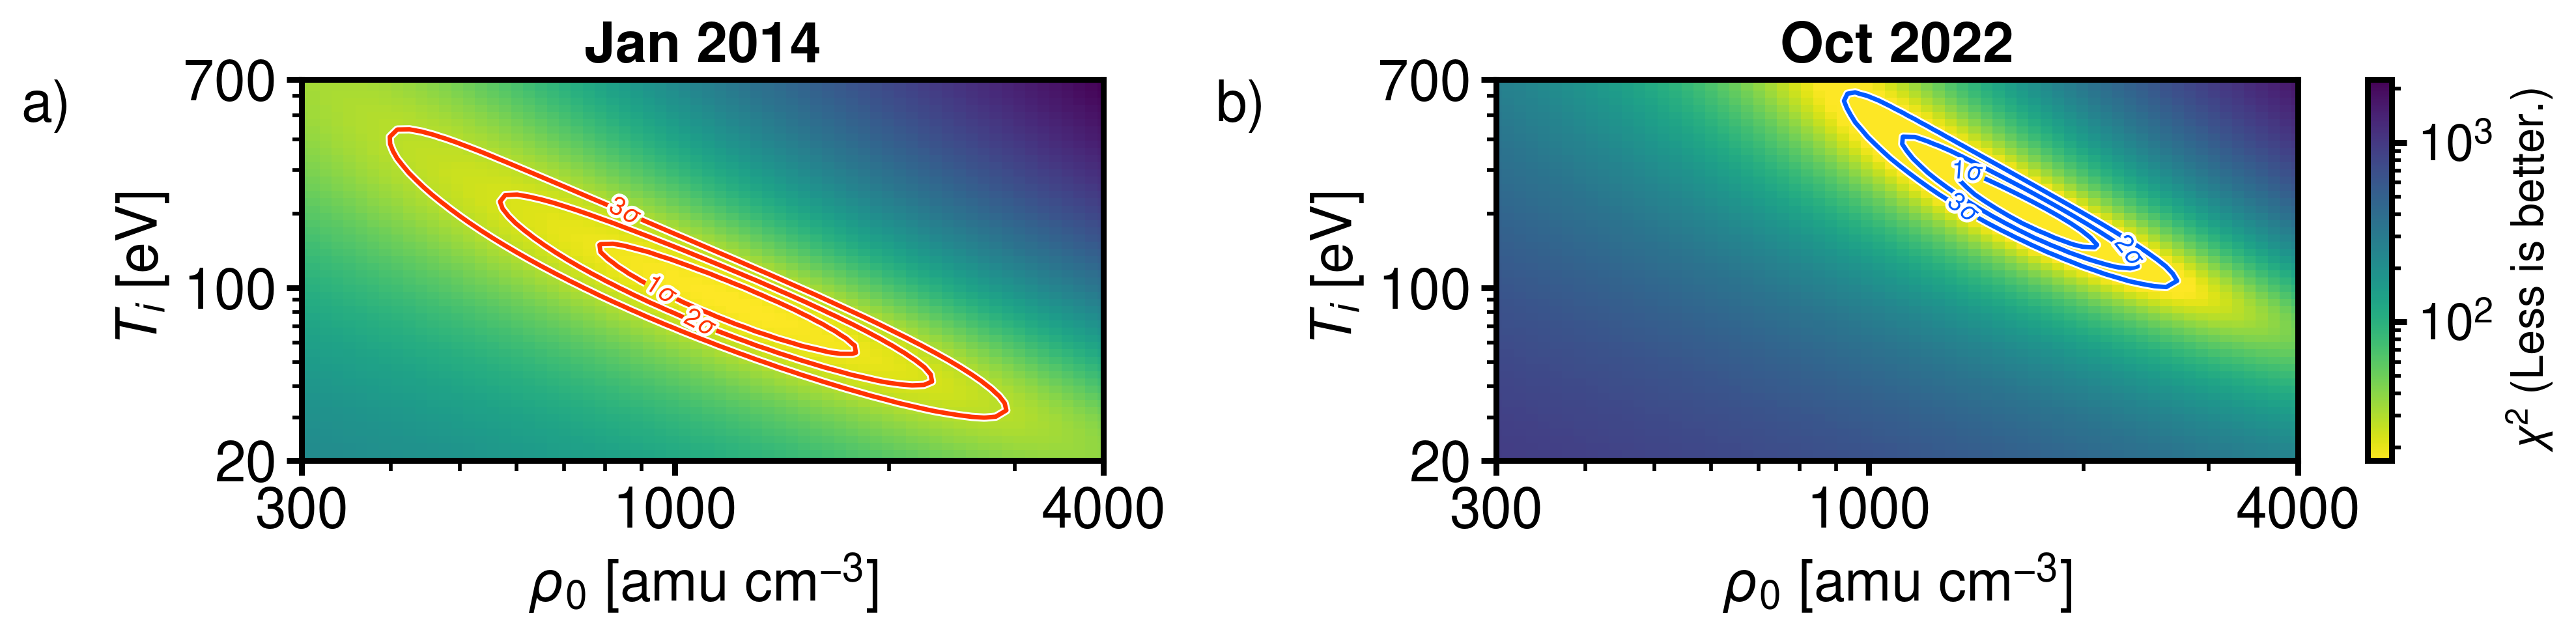

In [27]:
# CHI-SQUARE MAPPING
fontsize = 19
fig, ax = plt.subplots(1,2, figsize=(11.4,3.1), dpi=326)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].set_xlabel(r'$\rho_{\, 0}$ [amu cm$^{-3}$]', fontsize=fontsize)
    ax[i].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(300,4000)
    ax[i].set_ylim(20,700)
    ax[i].set_xticks(np.array([300,1000,4000], dtype=int))
    ax[i].set_xticklabels(np.array([300,1000,4000], dtype=int))
    ax[i].set_yticks(np.array([20,100,700], dtype=int))
    ax[i].set_yticklabels(np.array([20,100,700], dtype=int))
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)




yr = ['14', '22']
date = ['Jan 2014', 'Oct 2022']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    ax[i].set_title(date[i], weight='bold', fontsize=fontsize)
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    if i==0:
        lowerlimit = chi2min
        upperlimit = chi2max

    sm = ax[i].pcolor(RHO0, Ti0, chi2,
                   cmap='viridis_r', norm=colors.LogNorm(vmin=lowerlimit, vmax=upperlimit), zorder=1)
    
    cn = ax[i].contour(RHO0, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[i].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2.2, foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=2.8, foreground="w")])
    cn_list.append(cn)

fig.tight_layout()

axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1*1.03, axpos.y0, 0.01, axpos.y1-axpos.y0])
pp = fig.colorbar(sm, cax=cax)
pp.set_label('$\\chi^2$ (Less is better.)', fontsize=fontsize*0.8)
pp.ax.tick_params(labelsize=fontsize*0.9)
pp.ax.yaxis.get_offset_text().set_fontsize(fontsize*0.8)  # 指数部のフォントサイズ


plt.plot()

(array([16]), array([36])) rho_min [1206.60730149] Ti_min [58.5010613]
(array([22]), array([36])) rho_min [1206.60730149] Ti_min [87.49110484]


[]

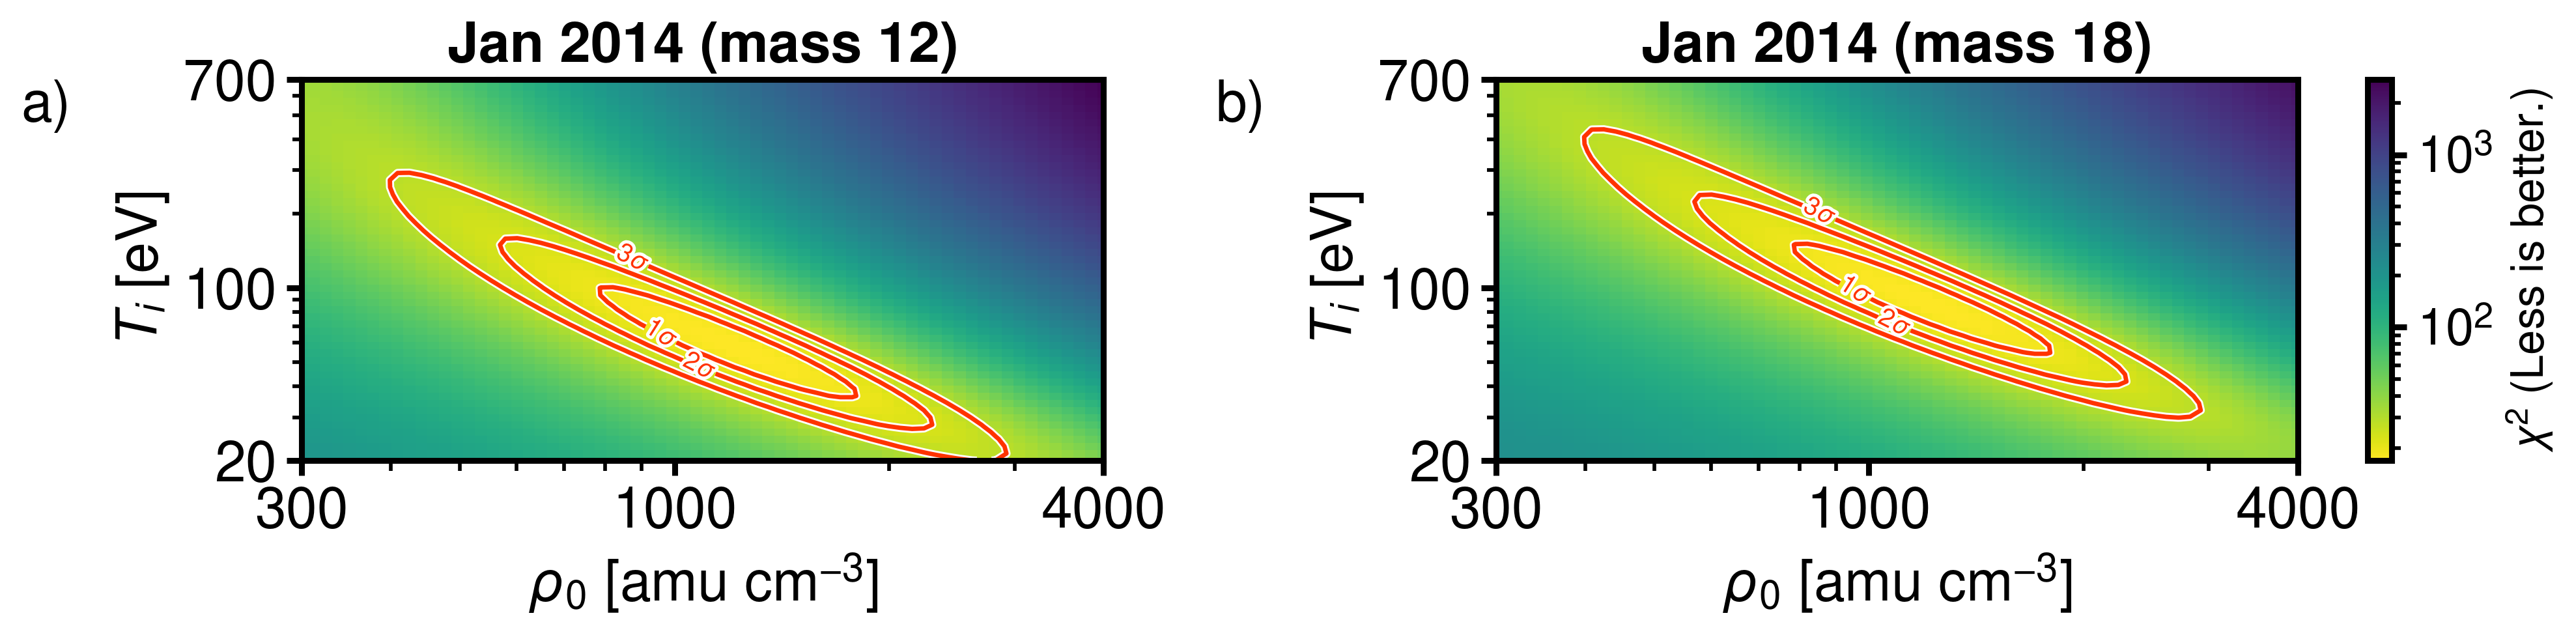

In [28]:
# CHI-SQUARE MAPPING
fontsize = 19
fig, ax = plt.subplots(1,2, figsize=(11.4,3.1), dpi=326)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].set_xlabel(r'$\rho_{\, 0}$ [amu cm$^{-3}$]', fontsize=fontsize)
    ax[i].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(300,4000)
    ax[i].set_ylim(20,700)
    ax[i].set_xticks(np.array([300,1000,4000], dtype=int))
    ax[i].set_xticklabels(np.array([300,1000,4000], dtype=int))
    ax[i].set_yticks(np.array([20,100,700], dtype=int))
    ax[i].set_yticklabels(np.array([20,100,700], dtype=int))
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)




yr = ['14_R4_12B', '14_R4']
date = ['Jan 2014 (mass 12)', 'Jan 2014 (mass 18)']
redblue = [cud4[0], cud4[0]]
cn_list = []
for i in range(2):
    ax[i].set_title(date[i], weight='bold', fontsize=fontsize)
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    if i==0:
        lowerlimit = chi2min
        upperlimit = chi2max

    sm = ax[i].pcolor(RHO0, Ti0, chi2,
                   cmap='viridis_r', norm=colors.LogNorm(vmin=lowerlimit, vmax=upperlimit), zorder=1)
    
    cn = ax[i].contour(RHO0, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[i].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2.2, foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=2.8, foreground="w")])
    cn_list.append(cn)

fig.tight_layout()

axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1*1.03, axpos.y0, 0.01, axpos.y1-axpos.y0])
pp = fig.colorbar(sm, cax=cax)
pp.set_label('$\\chi^2$ (Less is better.)', fontsize=fontsize*0.8)
pp.ax.tick_params(labelsize=fontsize*0.9)
pp.ax.yaxis.get_offset_text().set_fontsize(fontsize*0.8)  # 指数部のフォントサイズ


plt.plot()

(array([28]), array([45])) rho_min [1708.74447204] Ti_min [130.84708648]
(array([34]), array([45])) rho_min [1708.74447204] Ti_min [195.68800819]


[]

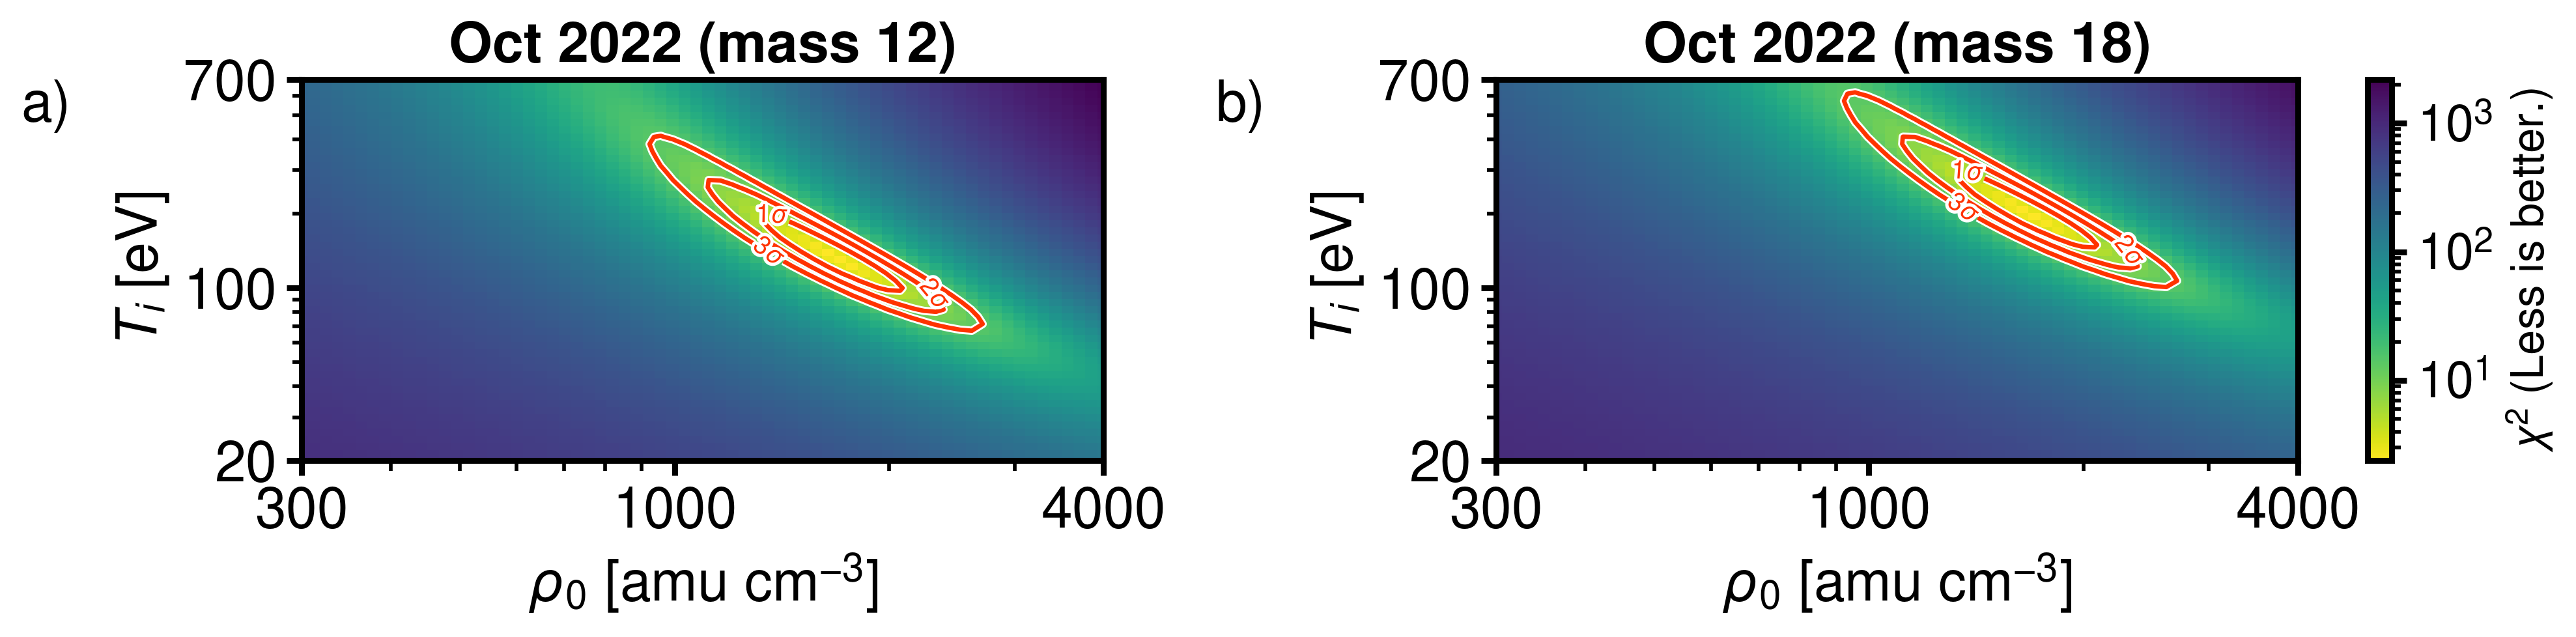

In [29]:
# CHI-SQUARE MAPPING
fontsize = 19
fig, ax = plt.subplots(1,2, figsize=(11.4,3.1), dpi=326)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].set_xlabel(r'$\rho_{\, 0}$ [amu cm$^{-3}$]', fontsize=fontsize)
    ax[i].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(300,4000)
    ax[i].set_ylim(20,700)
    ax[i].set_xticks(np.array([300,1000,4000], dtype=int))
    ax[i].set_xticklabels(np.array([300,1000,4000], dtype=int))
    ax[i].set_yticks(np.array([20,100,700], dtype=int))
    ax[i].set_yticklabels(np.array([20,100,700], dtype=int))
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)




yr = ['22_R4_12B', '22_R4']
date = ['Oct 2022 (mass 12)', 'Oct 2022 (mass 18)']
redblue = [cud4[0], cud4[0]]
cn_list = []
for i in range(2):
    ax[i].set_title(date[i], weight='bold', fontsize=fontsize)
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    if i==0:
        lowerlimit = chi2min
        upperlimit = chi2max

    sm = ax[i].pcolor(RHO0, Ti0, chi2,
                   cmap='viridis_r', norm=colors.LogNorm(vmin=lowerlimit, vmax=upperlimit), zorder=1)
    
    cn = ax[i].contour(RHO0, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[i].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2.2, foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=2.8, foreground="w")])
    cn_list.append(cn)

fig.tight_layout()

axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1*1.03, axpos.y0, 0.01, axpos.y1-axpos.y0])
pp = fig.colorbar(sm, cax=cax)
pp.set_label('$\\chi^2$ (Less is better.)', fontsize=fontsize*0.8)
pp.ax.tick_params(labelsize=fontsize*0.9)
pp.ax.yaxis.get_offset_text().set_fontsize(fontsize*0.8)  # 指数部のフォントサイズ


plt.plot()

rho [amu cm-3]: 788.632216749999 1206.6073014930985 1776.0993404086369
ne [cm-3]: 61.338061302777696 93.84723456057432 138.14105980956063
Ti [eV]: 54.70542364075105 87.49110484367995 149.6341687857023
1σ 左上の角 rho [amu cm-3]: 788.632216749999
1σ 左上の角 ne [cm-3]: 61.338061302777696
1σ 左上の角 Ti [eV]: 139.92567678546737
1σ 右下の角 rho [amu cm-3]: 1776.0993404086369
1σ 右下の角 ne [cm-3]: 138.14105980956063
1σ 右下の角 Ti [eV]: 54.70542364075105
3σ 上 Ti [eV] 100.05311620871885
3σ 下 Ti [eV] 76.50629702326802
3σ 左 rho [amu cm-3] 1033.7259708622457
3σ 右 rho [amu cm-3] 1354.9907804157608
rho [amu cm-3]: 1354.9907804157608 1708.7444720361773 2073.1359109867244
ne [cm-3]: 105.38817181011473 132.902347825036 161.24390418785634
Ti [eV]: 149.6341687857023 195.688008187844 292.66067421062564
1σ 左上の角 rho [amu cm-3]: 1354.9907804157608
1σ 左上の角 ne [cm-3]: 105.38817181011473
1σ 左上の角 Ti [eV]: 273.67240543876295
1σ 右下の角 rho [amu cm-3]: 2073.1359109867244
1σ 右下の角 ne [cm-3]: 161.24390418785634
1σ 右下の角 Ti [eV]: 149.634168

[]

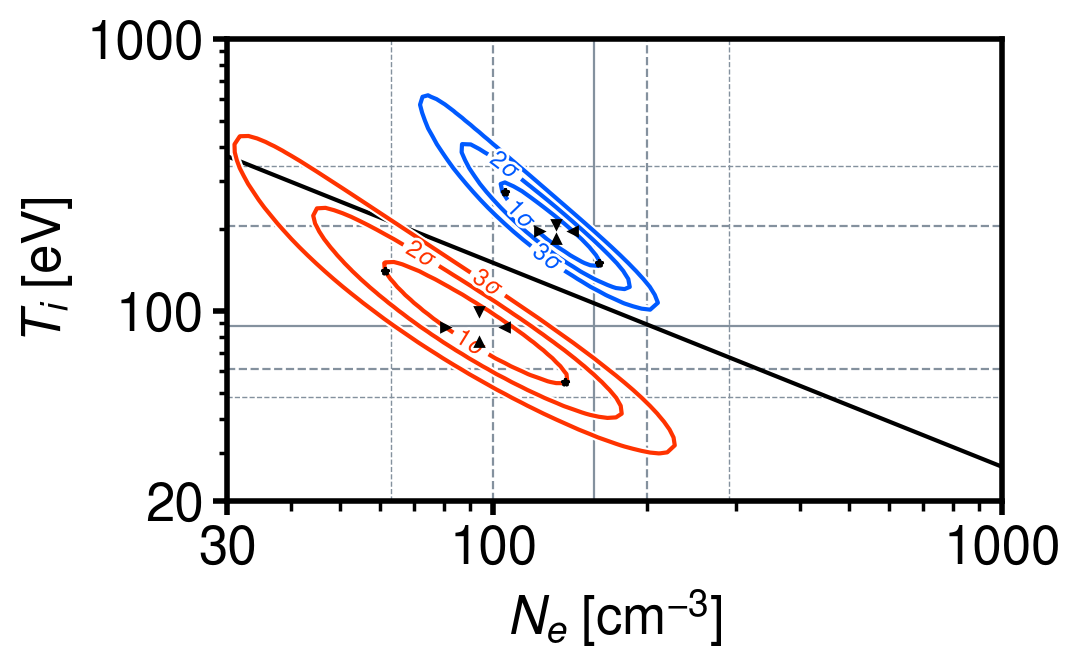

In [30]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(figsize=(5,3), dpi=200)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax.set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(30,1000)
ax.set_ylim(20,1000)
ax.set_xticks(np.array([30,100,1000], dtype=int))
ax.set_xticklabels(np.array([30,100,1000], dtype=int))
ax.set_yticks(np.array([20,100,1000], dtype=int))
ax.set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    # print(chi2min_pos)

    # 1シグマの区間を知りたい
    chi2_1sig_pos = np.where(chi2<=chi2min+2.30)
    RHO0_1sig = RHO0[chi2_1sig_pos]
    Ti0_1sig = Ti0[chi2_1sig_pos]
    print('rho [amu cm-3]:', np.min(RHO0_1sig), RHO0[chi2min_pos][0], np.max(RHO0_1sig))
    print('ne [cm-3]:', np.min(RHO0_1sig)*Zi/Ai, RHO0[chi2min_pos][0]*Zi/Ai, np.max(RHO0_1sig)*Zi/Ai)
    print('Ti [eV]:', np.min(Ti0_1sig), Ti0[chi2min_pos][0], np.max(Ti0_1sig))

    # 1シグマ等高線の角
    chi2_1sig_pos = np.where(chi2<=chi2min+2.30)
    # chi2_1sig_pos = np.where(chi2<=chi2min+11.8)
    RHO0_1sig = RHO0[chi2_1sig_pos]
    Ti0_1sig = Ti0[chi2_1sig_pos]
    print('1σ 左上の角 rho [amu cm-3]:', RHO0_1sig[np.where(RHO0_1sig==np.min(RHO0_1sig))][0])
    print('1σ 左上の角 ne [cm-3]:', RHO0_1sig[np.where(RHO0_1sig==np.min(RHO0_1sig))][0]*Zi/Ai)
    print('1σ 左上の角 Ti [eV]:', Ti0_1sig[np.where(RHO0_1sig==np.min(RHO0_1sig))][0])
    ax.plot(np.min(RHO0_1sig)*Zi/Ai, Ti0_1sig[np.where(RHO0_1sig==np.min(RHO0_1sig))][0], marker='*', markersize=3, color='k', zorder=5)
    print('1σ 右下の角 rho [amu cm-3]:', RHO0_1sig[np.where(RHO0_1sig==np.max(RHO0_1sig))][0])
    print('1σ 右下の角 ne [cm-3]:', RHO0_1sig[np.where(RHO0_1sig==np.max(RHO0_1sig))][0]*Zi/Ai)
    print('1σ 右下の角 Ti [eV]:', Ti0_1sig[np.where(RHO0_1sig==np.max(RHO0_1sig))][0])
    ax.plot(np.max(RHO0_1sig)*Zi/Ai, Ti0_1sig[np.where(RHO0_1sig==np.max(RHO0_1sig))][0], marker='*', markersize=3, color='k', zorder=5)

    # 3シグマの端 (片方のパラメータ固定)
    Ti_free = Ti0_1sig[np.where(RHO0_1sig==RHO0[chi2min_pos][0])]
    print('3σ 上 Ti [eV]', np.max(Ti_free))
    print('3σ 下 Ti [eV]', np.min(Ti_free))
    ax.plot(RHO0[chi2min_pos][0]*Zi/Ai, np.max(Ti_free), marker='v', markersize=3, color='k', zorder=5)
    ax.plot(RHO0[chi2min_pos][0]*Zi/Ai, np.min(Ti_free), marker='^', markersize=3, color='k', zorder=5)

    RHO0_free = RHO0_1sig[np.where(Ti0_1sig==Ti0[chi2min_pos][0])]
    print('3σ 左 rho [amu cm-3]', np.min(RHO0_free))
    print('3σ 右 rho [amu cm-3]', np.max(RHO0_free))
    ax.plot(np.min(RHO0_free)*Zi/Ai, Ti0[chi2min_pos][0], marker='>', markersize=3, color='k', zorder=5)
    ax.plot(np.max(RHO0_free)*Zi/Ai, Ti0[chi2min_pos][0], marker='<', markersize=3, color='k', zorder=5)

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax.contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax.clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

ax.plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax.axhline(y=340, color=cud4bs[7], linewidth=0.5, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax.axvline(x=63, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # H/C
ax.axhline(y=205, color=cud4bs[7], linewidth=0.8, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax.axvline(x=100, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 25
ax.axhline(y=88, color=cud4bs[7], linewidth=0.8, label='Median', zorder=0.9)  # Medium
ax.axvline(x=158, color=cud4bs[7], linewidth=0.8, zorder=0.9)                        # Medium
ax.axhline(y=61, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)     # 25
ax.axvline(x=200, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 75
ax.axhline(y=48, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # L/H
ax.axvline(x=290, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)  # L/H

# fig.tight_layout()
# fig.savefig('img/LeadangleFitResults/Fit_R4/Confidence_R4_north.png', transparent=True)
plt.plot()

In [31]:
for i in range(2):
    print(yr[i], '===')
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    # print(chi2min_pos)

    # 1シグマ等高線の角
    chi2_1sig_pos = np.where(chi2<=chi2min+2.30)
    N = chi2_1sig_pos[0].size
    # chi2_1sig_pos = np.where(chi2<=chi2min+11.8)
    RHO0_1sig = RHO0[chi2_1sig_pos]
    Ti0_1sig = Ti0[chi2_1sig_pos]

    J = np.random.randint(0,N,size=12)
    print('Rho')
    print(RHO0_1sig[J])
    print('Ti')
    print(Ti0_1sig[J])

14 ===
Rho
[1408.40147298 1206.60730149  956.80881247  956.80881247 1408.40147298
 1581.60074835  819.71832706 1354.99078042  956.80881247 1303.60557713
 1303.60557713 1160.84923261]
Ti
[ 76.50629702  87.49110484 114.4187867  122.3575289   76.50629702
  62.56005246 149.63416879  66.90066944 106.99512214  93.56151816
  71.54245234 100.05311621]
22 ===
Rho
[1708.74447204 1643.94389677 1846.10918638 1408.40147298 2073.13591099
 1776.09934041 1776.09934041 1581.60074835 2073.13591099 1708.74447204
 1521.621834   1643.94389677]
Ti
[209.26546949 182.99147318 182.99147318 255.91612437 149.63416879
 182.99147318 195.68800819 223.78497859 149.63416879 195.68800819
 209.26546949 182.99147318]


(array([20]), array([40])) rho_min [1703.49766284] 132.49426266500836 Ti_min [72.49782206]
(array([30]), array([51])) rho_min [2746.3262062] 213.60314937140663 Ti_min [138.02966758]


[]

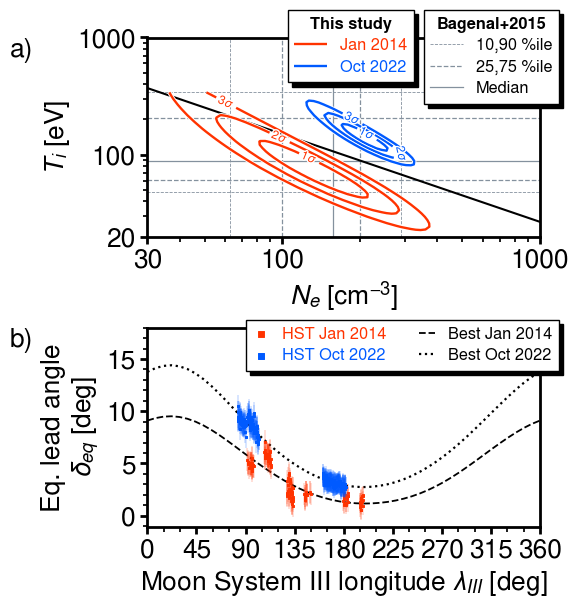

In [32]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=100)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,1000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], RHO0[chi2min_pos][0]*Zi/Ai, 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)


ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fontsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc14 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[0],
                linewidths=0.65, zorder=1)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                linestyle='none', ecolor=cud4[0], elinewidth=0.22, marker='none', zorder=1)
    if i == 0:
        sc14.set_label('HST Jan 2014')
        
# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[3],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4[3], elinewidth=0.22, marker='none', zorder=1.5)
    if i == 0:
        sc22.set_label('HST Oct 2022')

# Bestfit - 2014 North
data = np.loadtxt('bestfit14_8_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='Best Jan 2014', zorder=0.8)

# Bestfit - 2022 North
data = np.loadtxt('bestfit22_8_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='Best Oct 2022', zorder=0.8)

fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0075)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0075)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.08),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k', 'g']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

(array([22]), array([36])) rho_min [1206.60730149] 93.84723456057432 Ti_min [87.49110484]
(array([34]), array([45])) rho_min [1708.74447204] 132.902347825036 Ti_min [195.68800819]


[]

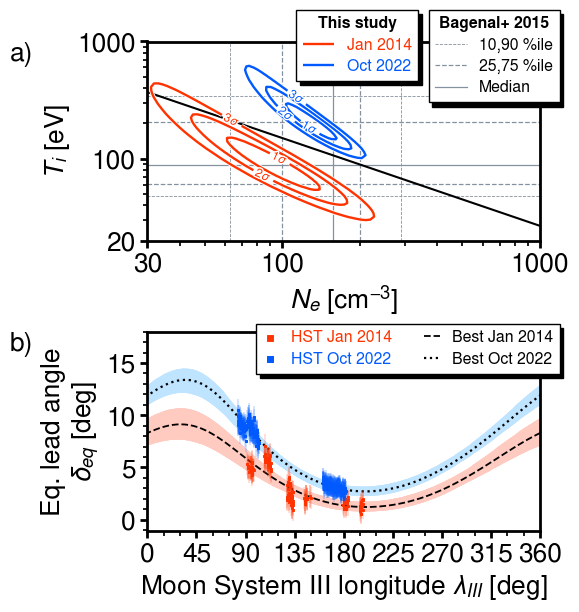

In [33]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=100)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,1000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], RHO0[chi2min_pos][0]*Zi/Ai, 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)


ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fontsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc14 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[0],
                linewidths=0.65, zorder=1)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                linestyle='none', ecolor=cud4[0], elinewidth=0.22, marker='none', zorder=1)
    if i == 0:
        sc14.set_label('HST Jan 2014')
        
# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[3],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4[3], elinewidth=0.22, marker='none', zorder=1.5)
    if i == 0:
        sc22.set_label('HST Oct 2022')

# Bestfit - 2014 North
data = np.loadtxt('img/LeadangleFit/2014_R4/bestfit.txt')
ax[1].plot(data[0,:], data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='Best Jan 2014', zorder=0.8)

# 3-sigma borders
exname = '2014_R4'
s3wlon = np.linspace(0, 362, 122)
Upper = np.zeros(s3wlon.size-1)
Lower = np.zeros(s3wlon.size-1)
Left = np.zeros(s3wlon.size-1)
Right = np.zeros(s3wlon.size-1)
for i in range(s3wlon.size-1):
    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Upper.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Upper[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Lower.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Lower[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Left.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Left[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Right.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Right[i] = np.average(data_arr[1, :][cut])

fillcolor = cud4bs[0]
ax[1].fill_between(s3wlon[:-1], Left, Right,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Lower, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)

# Bestfit - 2022 North
data = np.loadtxt('img/LeadangleFit/2022_R4/bestfit.txt')
ax[1].plot(data[0,:], data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='Best Oct 2022', zorder=0.8)

# 3-sigma borders
exname = '2022_R4'
s3wlon = np.linspace(0, 362, 122)
Upper = np.zeros(s3wlon.size-1)
Lower = np.zeros(s3wlon.size-1)
Left = np.zeros(s3wlon.size-1)
Right = np.zeros(s3wlon.size-1)
for i in range(s3wlon.size-1):
    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Upper.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Upper[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Lower.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Lower[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Left.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Left[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Right.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Right[i] = np.average(data_arr[1, :][cut])

fillcolor = cud4bs[3]
ax[1].fill_between(s3wlon[:-1], Left, Right,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Lower, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)

fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.20),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+ 2015', prop={'size': fontsize*0.6, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0073)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.71, 1.20),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.6, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0073)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.08),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k', 'g']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

(array([22]), array([36])) rho_min 1206.6073014930985 Ti_min [87.49110484]
(array([34]), array([45])) rho_min 1708.7444720361773 Ti_min [195.68800819]


[]

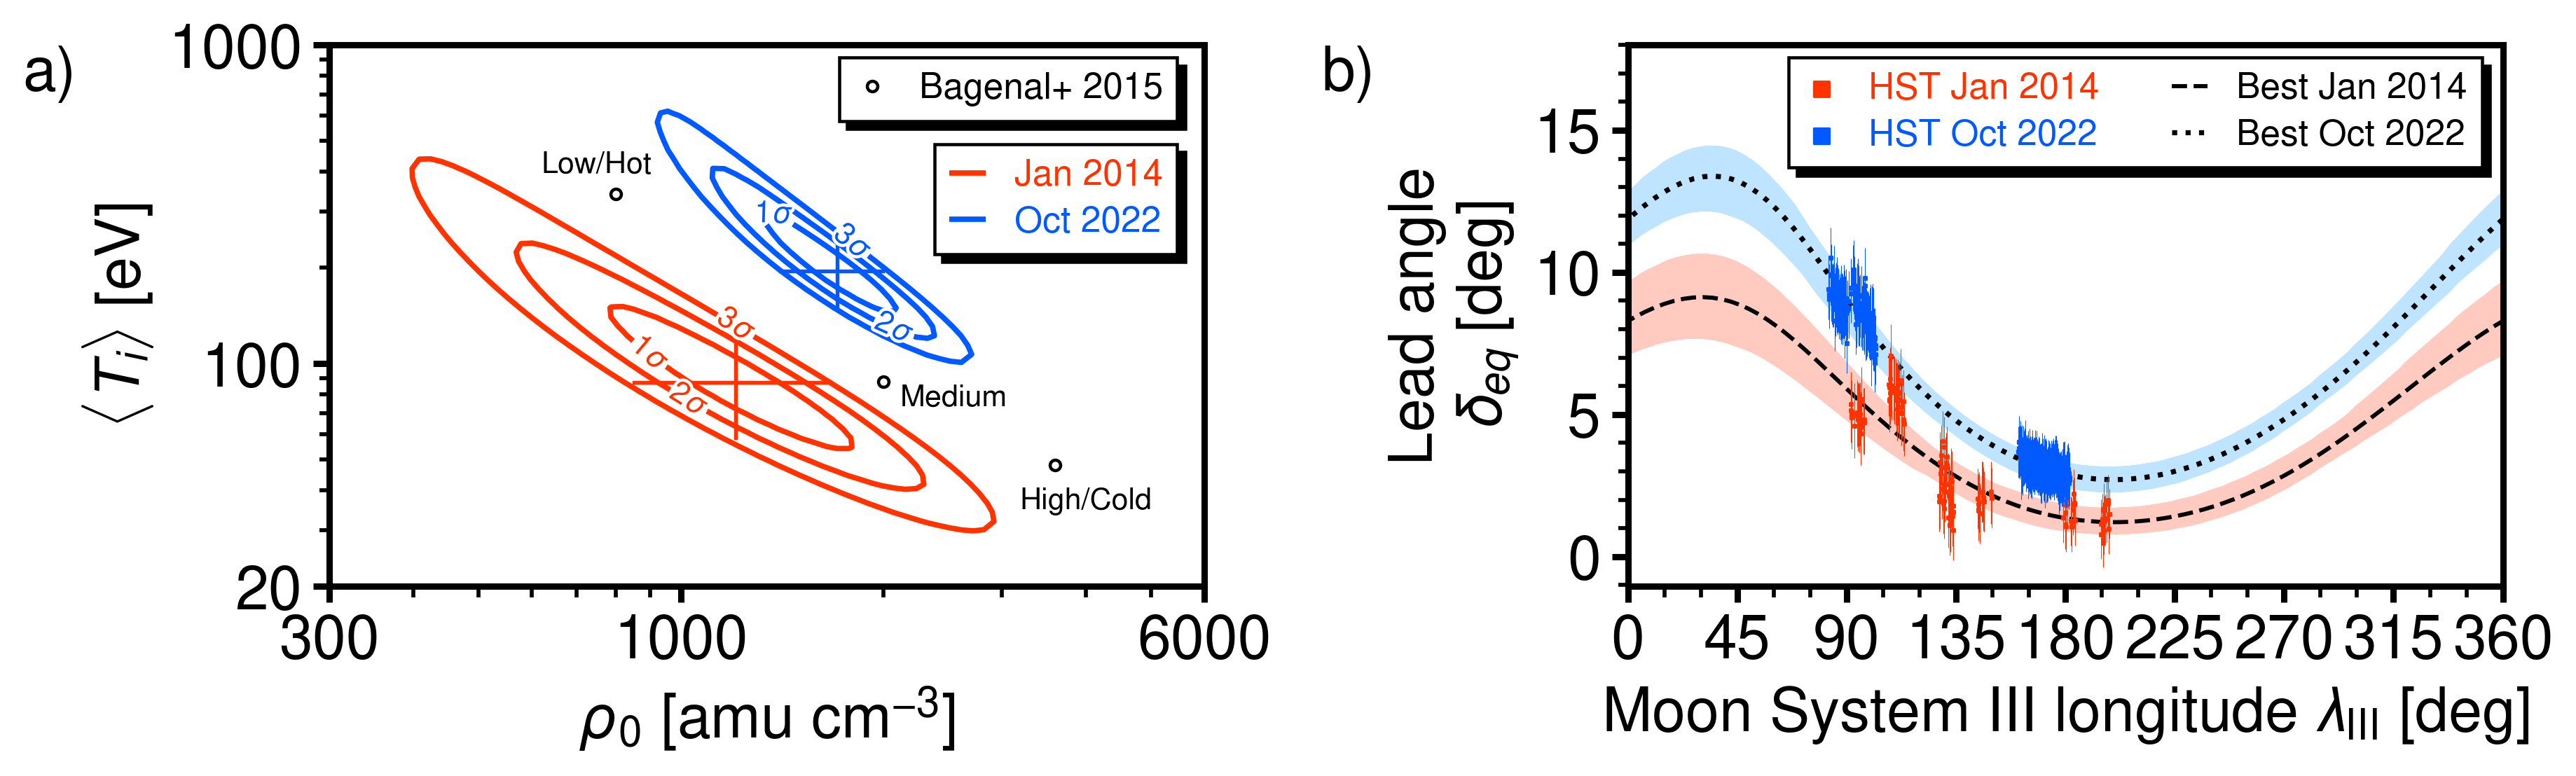

In [34]:
# Plot
fontsize = 19
fig, ax = plt.subplots(1,2, figsize=(11.45,3.5), dpi=326)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel(r'$\rho_{\, 0}$ [amu cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel(r'$\langle T_i \rangle$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(300,6000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([300,1000,6000], dtype=int))
ax[0].set_xticklabels(np.array([300,1000,6000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos][0], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour(RHO0, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.50)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    # plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

# 上下 2014
ax[0].plot(np.array([1206.6073014930985,1206.6073014930985]),
           np.array([58.501061296304314,130.8470864827091]),
           color=cud4[0], linewidth=1.2, zorder=0.5)

# 左右 2014
ax[0].plot(np.array([852.0297820080574,1643.9438967656056]),
           np.array([87.49110484367995,87.49110484367995]),
           color=cud4[0], linewidth=1.2, zorder=0.5)

# 上下 2022
ax[0].plot(np.array([1708.7444720361773,1708.7444720361773]),
           np.array([149.6341687857023,255.91612436707533]),
           color=cud4[3], linewidth=1.2, zorder=0.5)

# 左右 2022
ax[0].plot(np.array([1408.4014729765076,1994.5165493182474]),
           np.array([195.688008187844,195.688008187844]),
           color=cud4[3], linewidth=1.2, zorder=0.5)

# Bagenal+2015
ax[0].plot(800, 340, label='Bagenal+ 2015', linestyle='none',
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].plot(2000, 88, 
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].plot(3600, 48, 
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].text(750, 420,
           'Low/Hot',
           color='k',
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=fontsize*0.50,)
ax[0].text(2120, 78,
           'Medium',
           color='k',
           horizontalalignment='left',
           verticalalignment='center',
           # transform=ax[0].transAxes,
           fontsize=fontsize*0.50,)
           # path_effects=[pe.withStroke(linewidth=2.5, foreground='white')])
ax[0].text(4000, 37,
           'High/Cold',
           color='k',
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=fontsize*0.50,)


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fontsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc14 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[0],
                linewidths=0.65, zorder=1)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                linestyle='none', ecolor=cud4[0], elinewidth=0.22, marker='none', zorder=1)
    if i == 0:
        sc14.set_label('HST Jan 2014')
        
# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[3],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4[3], elinewidth=0.22, marker='none', zorder=1.5)
    if i == 0:
        sc22.set_label('HST Oct 2022')

# Bestfit - 2014 North
data = np.loadtxt('img/LeadangleFit/2014_R4/bestfit.txt')
ax[1].plot(data[0,:], data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='Best Jan 2014', zorder=0.8)

# 3-sigma borders
exname = '2014_R4'
s3wlon = np.linspace(0, 362, 122)
Upper = np.zeros(s3wlon.size-1)
Lower = np.zeros(s3wlon.size-1)
Left = np.zeros(s3wlon.size-1)
Right = np.zeros(s3wlon.size-1)
for i in range(s3wlon.size-1):
    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Upper.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Upper[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Lower.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Lower[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Left.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Left[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Right.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Right[i] = np.average(data_arr[1, :][cut])

fillcolor = cud4bs[0]
ax[1].fill_between(s3wlon[:-1], Left, Right,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Lower, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)

# Bestfit - 2022 North
data = np.loadtxt('img/LeadangleFit/2022_R4/bestfit.txt')
ax[1].plot(data[0,:], data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='Best Oct 2022', zorder=0.8)

# 3-sigma borders
exname = '2022_R4'
s3wlon = np.linspace(0, 362, 122)
Upper = np.zeros(s3wlon.size-1)
Lower = np.zeros(s3wlon.size-1)
Left = np.zeros(s3wlon.size-1)
Right = np.zeros(s3wlon.size-1)
for i in range(s3wlon.size-1):
    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Upper.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Upper[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Lower.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Lower[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Left.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Left[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Right.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Right[i] = np.average(data_arr[1, :][cut])

fillcolor = cud4bs[3]
ax[1].fill_between(s3wlon[:-1], Left, Right,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Lower, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)

"""
# ==================
# Hue+ 2023 Fittiing
# ==================
lam = np.radians(np.linspace(0,360,60))
delta_Hue = 5.78 + 3.29*np.cos(0.99*lam) \
        +1.41*np.sin(0.99*lam)

ax[1].plot(np.degrees(lam), delta_Hue,
           linestyle='dotted', linewidth=1.6, color='purple',
           label=None, zorder=5)
"""

fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
# first legend
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(0.99, 1.01),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.60,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.003, dy=-0.010)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.99, 0.85),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,
                    handlelength=1,)
# legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.003, dy=-0.010)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper center',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(0.58, 1.01),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.003, dy=-0.010)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k', 'g']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

(array([22]), array([36])) rho_min 1206.6073014930985 Ti_min [87.49110484]
(array([34]), array([45])) rho_min 1708.7444720361773 Ti_min [195.68800819]


[]

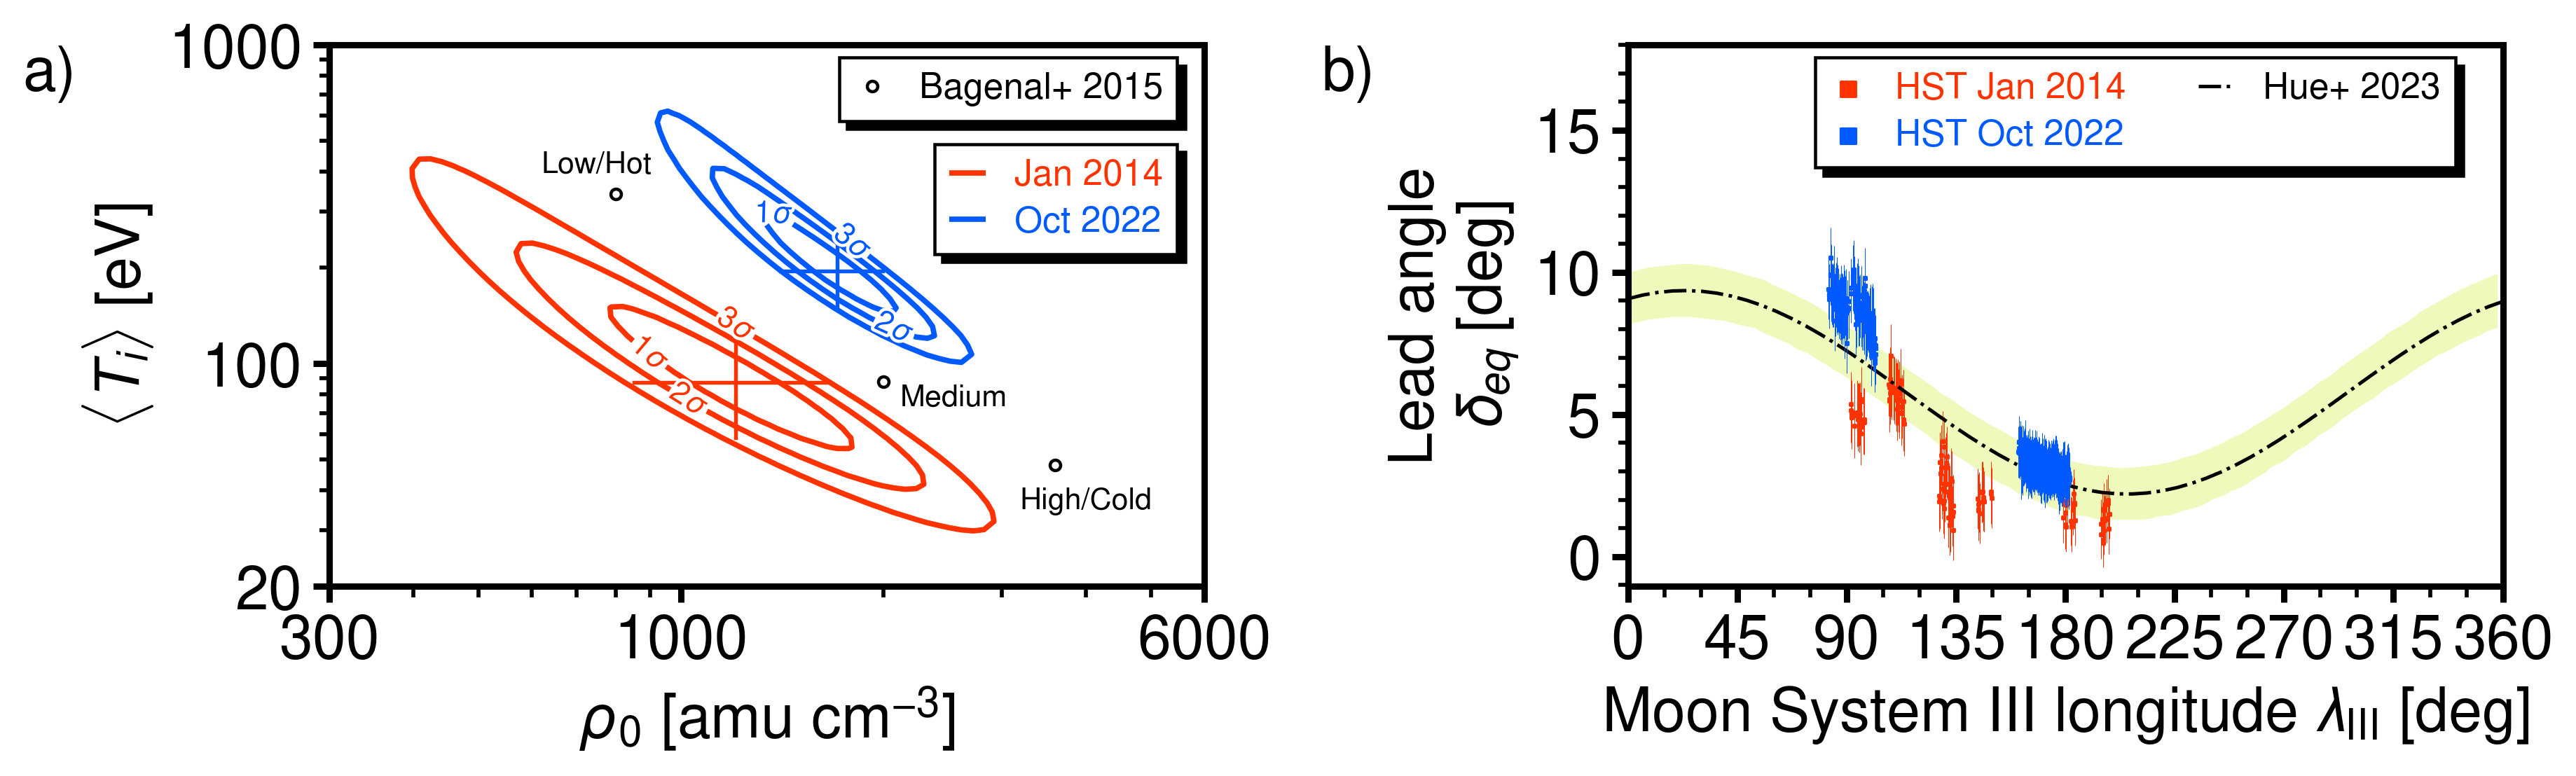

In [35]:
# Plot
fontsize = 19
fig, ax = plt.subplots(1,2, figsize=(11.45,3.5), dpi=326)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel(r'$\rho_{\, 0}$ [amu cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel(r'$\langle T_i \rangle$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(300,6000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([300,1000,6000], dtype=int))
ax[0].set_xticklabels(np.array([300,1000,6000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos][0], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour(RHO0, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.50)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    # plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

# 上下 2014
ax[0].plot(np.array([1206.6073014930985,1206.6073014930985]),
           np.array([58.501061296304314,130.8470864827091]),
           color=cud4[0], linewidth=1.2, zorder=0.5)

# 左右 2014
ax[0].plot(np.array([852.0297820080574,1643.9438967656056]),
           np.array([87.49110484367995,87.49110484367995]),
           color=cud4[0], linewidth=1.2, zorder=0.5)

# 上下 2022
ax[0].plot(np.array([1708.7444720361773,1708.7444720361773]),
           np.array([149.6341687857023,255.91612436707533]),
           color=cud4[3], linewidth=1.2, zorder=0.5)

# 左右 2022
ax[0].plot(np.array([1408.4014729765076,1994.5165493182474]),
           np.array([195.688008187844,195.688008187844]),
           color=cud4[3], linewidth=1.2, zorder=0.5)

# Bagenal+2015
ax[0].plot(800, 340, label='Bagenal+ 2015', linestyle='none',
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].plot(2000, 88, 
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].plot(3600, 48, 
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].text(750, 420,
           'Low/Hot',
           color='k',
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=fontsize*0.50,)
ax[0].text(2120, 78,
           'Medium',
           color='k',
           horizontalalignment='left',
           verticalalignment='center',
           # transform=ax[0].transAxes,
           fontsize=fontsize*0.50,)
           # path_effects=[pe.withStroke(linewidth=2.5, foreground='white')])
ax[0].text(4000, 37,
           'High/Cold',
           color='k',
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=fontsize*0.50,)


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fontsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc14 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[0],
                linewidths=0.65, zorder=1)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                linestyle='none', ecolor=cud4[0], elinewidth=0.22, marker='none', zorder=1)
    if i == 0:
        sc14.set_label('HST Jan 2014')
        
# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[3],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4[3], elinewidth=0.22, marker='none', zorder=1.5)
    if i == 0:
        sc22.set_label('HST Oct 2022')


# ==================
# Hue+ 2023 Fittiing
# ==================
data_H = np.loadtxt('data/Hue23_plus.csv', dtype=np.float64, delimiter=',')
data_Hx = data_H[:,0]
data_H2 = data_H[:,1]
data_H1 = np.loadtxt('data/Hue23_minus.csv', dtype=np.float64, delimiter=',')[:,1]
ax[1].fill_between(data_Hx, data_H2, data_H1,
                facecolor=cud4bs[2], alpha=0.4, zorder=0.6)

lam = np.radians(np.linspace(0,360,60))
delta_Hue = 5.78 + 3.29*np.cos(0.99*lam) \
        +1.41*np.sin(0.99*lam)

ax[1].plot(np.degrees(lam), delta_Hue,
           linestyle='-.', linewidth=1.1, color='k',
           label='Hue+ 2023', zorder=1)

fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
# first legend
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(0.99, 1.01),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.60,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.003, dy=-0.010)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.99, 0.85),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,
                    handlelength=1,)
# legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.003, dy=-0.010)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper center',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(0.58, 1.01),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.003, dy=-0.010)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k', 'g']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

(array([22]), array([36])) rho_min 1206.6073014930985 Ti_min [87.49110484]
(array([34]), array([45])) rho_min 1708.7444720361773 Ti_min [195.68800819]


[]

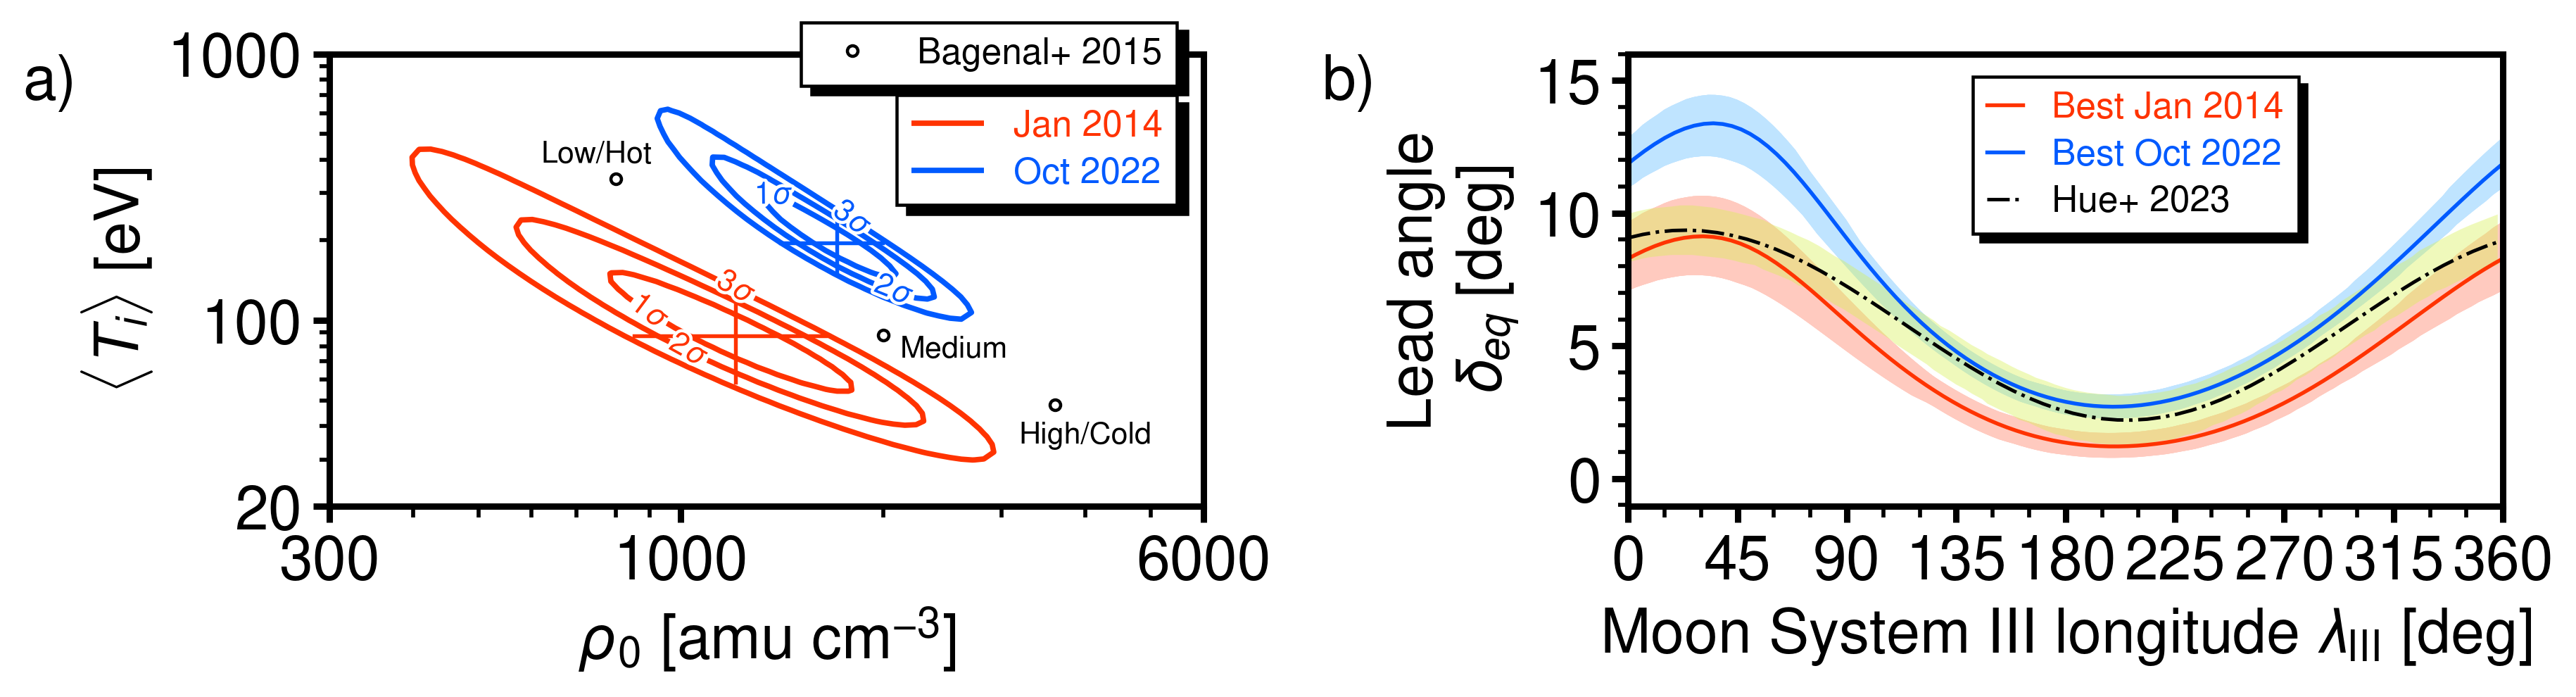

In [36]:
# Plot
fontsize = 19
fig, ax = plt.subplots(1,2, figsize=(11.4,3.1), dpi=326)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel(r'$\rho_{\, 0}$ [amu cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel(r'$\langle T_i \rangle$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(300,6000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([300,1000,6000], dtype=int))
ax[0].set_xticklabels(np.array([300,1000,6000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_R4/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos][0], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour(RHO0, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.50)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    # plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

# 上下 2014
ax[0].plot(np.array([1206.6073014930985,1206.6073014930985]),
           np.array([58.501061296304314,130.8470864827091]),
           color=cud4[0], linewidth=1.2, zorder=0.5)

# 左右 2014
ax[0].plot(np.array([852.0297820080574,1643.9438967656056]),
           np.array([87.49110484367995,87.49110484367995]),
           color=cud4[0], linewidth=1.2, zorder=0.5)

# 上下 2022
ax[0].plot(np.array([1708.7444720361773,1708.7444720361773]),
           np.array([149.6341687857023,255.91612436707533]),
           color=cud4[3], linewidth=1.2, zorder=0.5)

# 左右 2022
ax[0].plot(np.array([1408.4014729765076,1994.5165493182474]),
           np.array([195.688008187844,195.688008187844]),
           color=cud4[3], linewidth=1.2, zorder=0.5)

# Bagenal+2015
ax[0].plot(800, 340, label='Bagenal+ 2015', linestyle='none',
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].plot(2000, 88, 
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].plot(3600, 48, 
           marker='o', markersize=3.3, markeredgecolor = 'k', mfc='none', zorder=2)
ax[0].text(750, 420,
           'Low/Hot',
           color='k',
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=fontsize*0.50,)
ax[0].text(2120, 78,
           'Medium',
           color='k',
           horizontalalignment='left',
           verticalalignment='center',
           # transform=ax[0].transAxes,
           fontsize=fontsize*0.50,)
           # path_effects=[pe.withStroke(linewidth=2.5, foreground='white')])
ax[0].text(4000, 37,
           'High/Cold',
           color='k',
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=fontsize*0.50,)


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 16)
ax[1].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fontsize)
ax[1].set_yticks(np.arange(0, 16, 5))
ax[1].set_yticklabels(np.arange(0, 16, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    # sc14 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[0],
    #             linewidths=0.65, zorder=1)
    # ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
    #             linestyle='none', ecolor=cud4[0], elinewidth=0.22, marker='none', zorder=1)
    if i == 0:
        sc14.set_label('HST Jan 2014')
        
# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    # sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[3],
    #               linewidths=0.7, zorder=1.5)
    # ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
    #                linestyle='none', ecolor=cud4[3], elinewidth=0.22, marker='none', zorder=1.5)
    if i == 0:
        sc22.set_label('HST Oct 2022')

# Bestfit - 2014 North
data = np.loadtxt('img/LeadangleFit/2014_R4/bestfit.txt')
ax[1].plot(data[0,:], data[1,:],
           linewidth=1.2, color=cud4[0],
           label='Best Jan 2014', zorder=0.8)

# 3-sigma borders
exname = '2014_R4'
s3wlon = np.linspace(0, 362, 122)
Upper = np.zeros(s3wlon.size-1)
Lower = np.zeros(s3wlon.size-1)
Left = np.zeros(s3wlon.size-1)
Right = np.zeros(s3wlon.size-1)
for i in range(s3wlon.size-1):
    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Upper.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Upper[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Lower.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Lower[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Left.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Left[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Right.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Right[i] = np.average(data_arr[1, :][cut])

fillcolor = cud4bs[0]
ax[1].fill_between(s3wlon[:-1], Left, Right,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Lower, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)

# Bestfit - 2022 North
data = np.loadtxt('img/LeadangleFit/2022_R4/bestfit.txt')
ax[1].plot(data[0,:], data[1,:],
           linewidth=1.2, color=cud4[3],
           label='Best Oct 2022', zorder=0.8)

# 3-sigma borders
exname = '2022_R4'
s3wlon = np.linspace(0, 362, 122)
Upper = np.zeros(s3wlon.size-1)
Lower = np.zeros(s3wlon.size-1)
Left = np.zeros(s3wlon.size-1)
Right = np.zeros(s3wlon.size-1)
for i in range(s3wlon.size-1):
    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Upper.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Upper[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Lower.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Lower[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Left.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Left[i] = np.average(data_arr[1, :][cut])

    data_arr = np.loadtxt(
        'img/LeadangleFit/'+exname+'/bestfit_Right.txt')
    cut = np.where(((data_arr[0, :] >= s3wlon[i])
                    & (data_arr[0, :] < s3wlon[i+1])))
    Right[i] = np.average(data_arr[1, :][cut])

fillcolor = cud4bs[3]
ax[1].fill_between(s3wlon[:-1], Left, Right,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Left, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Lower,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Right, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)
ax[1].fill_between(s3wlon[:-1], Lower, Upper,
                facecolor=fillcolor, alpha=1, zorder=0.6)


# ==================
# Hue+ 2023 Fittiing
# ==================
data_H = np.loadtxt('data/Hue23_plus.csv', dtype=np.float64, delimiter=',')
data_Hx = data_H[:,0]
data_H2 = data_H[:,1]
data_H1 = np.loadtxt('data/Hue23_minus.csv', dtype=np.float64, delimiter=',')[:,1]
ax[1].fill_between(data_Hx, data_H2, data_H1,
                facecolor=cud4bs[2], alpha=0.4, zorder=0.6)

lam = np.radians(np.linspace(0,360,60))
delta_Hue = 5.78 + 3.29*np.cos(0.99*lam) \
        +1.41*np.sin(0.99*lam)

ax[1].plot(np.degrees(lam), delta_Hue,
           linestyle='-.', linewidth=1.1, color='k',
           label='Hue+ 2023', zorder=1)


fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
# first legend
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(0.99, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.60,
                    labelspacing=0.34,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.004, dy=-0.012)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.99, 0.95),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,)
# legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.004, dy=-0.012)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper center',
                    ncol=1,
                    markerscale=5,
                    bbox_to_anchor=(0.58, 0.99),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.6,
                    labelspacing=0.34,
                    handlelength=0.98,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.003, dy=-0.011)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k', 'g']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

In [37]:
data = np.loadtxt('data/Hue23_plus.csv', dtype=np.float64, delimiter=',')
print(data[:,0])

[  0.71428571   4.28571429   8.57142857  12.85714286  17.85714286
  21.42857143  26.42857143  30.71428571  35.          39.28571429
  43.57142857  47.14285714  52.14285714  55.71428571  59.28571429
  62.85714286  67.14285714  70.          74.28571429  78.57142857
  82.14285714  85.          88.57142857  91.42857143  95.
  97.85714286 101.42857143 104.28571429 107.85714286 110.
 113.57142857 116.42857143 120.         122.85714286 125.71428571
 128.57142857 132.14285714 135.         138.57142857 141.42857143
 145.71428571 147.85714286 150.71428571 153.57142857 157.85714286
 160.71428571 165.         167.85714286 172.14285714 175.71428571
 180.         183.57142857 188.57142857 192.14285714 197.14285714
 201.42857143 205.71428571 210.71428571 215.         218.57142857
 223.57142857 229.28571429 233.57142857 237.14285714 240.71428571
 245.         248.57142857 252.14285714 255.71428571 258.57142857
 262.14285714 265.         269.28571429 272.14285714 275.
 278.57142857 281.42857143 284.285